# Finite Mixture Models

# Q2

## (b)
Fit the galaxy dataset using the mixture modeling with the Gibbs sampling. You must choose reasonable hyper-parameters and H (a histogram may be useful to determine H). Specify the values of hyper-parameters and H you use. Find the pointwise posterior mean curve and 95% credible band of the density function.

In [1]:
### library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from scipy.stats import norm, invgamma

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(suppress=True)

### Read data

In [2]:
galaxy = np.loadtxt('galaxy.txt', skiprows=1)[:, 1]  # speed
galaxy

array([ 9.172,  9.35 ,  9.483,  9.558,  9.775, 10.227, 10.406, 16.084,
       16.17 , 18.419, 18.552, 18.6  , 18.927, 19.052, 19.07 , 19.33 ,
       19.343, 19.349, 19.44 , 19.473, 19.529, 19.541, 19.547, 19.663,
       19.846, 19.856, 19.863, 19.914, 19.918, 19.973, 19.989, 20.166,
       20.175, 20.179, 20.196, 20.215, 20.221, 20.415, 20.629, 20.795,
       20.821, 20.846, 20.875, 20.986, 21.137, 21.492, 21.701, 21.814,
       21.921, 21.96 , 22.185, 22.209, 22.242, 22.249, 22.314, 22.374,
       22.495, 22.746, 22.747, 22.888, 22.914, 23.206, 23.241, 23.263,
       23.484, 23.538, 23.542, 23.666, 23.706, 23.711, 24.129, 24.285,
       24.289, 24.368, 24.717, 24.99 , 25.633, 26.96 , 26.995, 32.065,
       32.789, 34.279])

### Choose H
Histogram을 통해서 3~4개의 Gaussian component를 가진 Gaussian mixture로 보인다. 즉 H = 3, 4 and 20을 실험해보겠다.

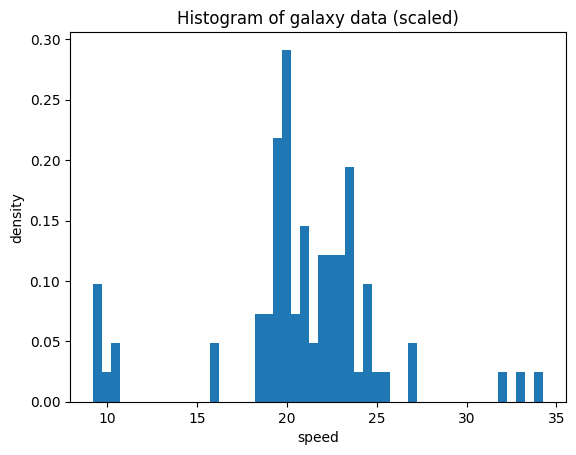

In [3]:
plt.hist(galaxy, bins=50, density=True)
plt.title('Histogram of galaxy data (scaled)')
plt.xlabel('speed')
plt.ylabel('density')
plt.show()

### Gibbs sampler

In [3]:
def gibbs_sampler(y, H=20, mu0=0, kappa=100, a=1, b=1, n_mcmc=2000, burn_in=2000):
    
    n = len(y)
    
    #############################################
    ## 1. Container
    #############################################
    z_samples = np.zeros((n_mcmc + burn_in, n))   
    pi_samples = np.zeros((n_mcmc + burn_in, H))
    mu_samples = np.zeros((n_mcmc + burn_in, H))
    tau2_samples = np.zeros((n_mcmc + burn_in, H))

    #############################################
    ## 2. Initialization
    #############################################
    pi_sample = np.ones((H, )) / H
    mu_sample = np.linspace(0, 30, H)
    tau2_sample= np.random.uniform(0, 1, H)
    dir_param = np.ones(H) / H

    #############################################
    ## 3. Gibbs sampler
    #############################################
    for s in range(n_mcmc + burn_in):
        ## 1. Update zi
        # a. Calculate prob(zi = h | -)
        z_prob = np.zeros((n, H))
        for i in range(n):
            # unnormalize prob of y_i for h (h = 1, ..., H)
            z_prob[i] = pi_sample * norm.pdf(y[i], mu_sample, np.sqrt(tau2_sample))  # (H, ) and mean and loc are vector
        z_prob[np.isnan(z_prob)] = 0  # for null component
        
        z_prob = z_prob / np.sum(z_prob, axis=1, keepdims=True)  # normalize; (n, H)

        # b. Sample z from z_prob
        z_sample = np.zeros(n)
        for i in range(n):
            z_sample[i] = np.random.choice(a=np.arange(0, H, 1), p=z_prob[i])  # scaler
        z_sample = z_sample.astype(int)

        ## 2. Update mu_h and tau2_h 
        # a. parameters conditional posterior distribution;
        # i) n_h and y_bar
        group_cnt = np.zeros(H); y_bar = np.zeros(H)
        for h in range(H):
            group_cnt[h] = sum(z_sample == h)
            y_bar[h] = np.mean(y[z_sample == h]) 
        group_cnt = group_cnt.astype(int)
        y_bar[np.isnan(y_bar)] = 0  # for null component

        # ii) K_hat
        kappa_inv = kappa**(-1)
        kappa_hat = (kappa_inv + group_cnt)**(-1)

        # iii) mu_hat
        mu_hat = kappa_hat * (kappa_inv * mu0 + group_cnt * y_bar)  # elementwise multiplication

        # iv) a_hat and b_hat
        a_hat = np.zeros(H); b_hat = np.zeros(H)
        for h in range(H):
            if group_cnt[h] == 0:
                a_hat[h] = a; b_hat[h] = b  # for null component
            else:
                a_hat[h] = a + group_cnt[h] / 2
                factor1 = sum((y[z_sample == h] - y_bar[h]) ** 2)
                factor2 = group_cnt[h] / (1 + kappa * group_cnt[h]) * ((y_bar[h] - mu0) ** 2)
                b_hat[h] = b + (factor1 + factor2) / 2 

        # b. Update tau2 in Inv-Gamma
        tau2_sample = np.zeros(H)  # new tau2_sample
        for h in range(H):
            tau2_sample[h] = invgamma.rvs(a=a_hat[h], scale=b_hat[h])

        # c. Update mu in Normal given tau2
        mu_sample = np.zeros(H)  # new mu_sample
        for h in range(H):
            mu_sample[h] = np.random.normal(loc=mu_hat[h], scale=np.sqrt(kappa_hat * tau2_sample)[h])
        mu_sample[np.isnan(mu_sample)] = 0  # for null component

        ## 3. Update pi
        dir_param = dir_param + group_cnt
        pi_sample = np.random.dirichlet(dir_param)  # new pi_sample

        #############################################
        ## 4. Save as mcmc samples
        #############################################
        z_samples[s, ] = z_sample
        pi_samples[s, ] = pi_sample
        mu_samples[s, ] = mu_sample
        tau2_samples[s, ] = tau2_sample
        
    #############################################
    ## 5. Burn-in
    #############################################
    z_samples = z_samples[burn_in: ]
    pi_samples = pi_samples[burn_in: ]
    mu_samples = mu_samples[burn_in: ]
    tau2_samples = tau2_samples[burn_in: ]

    return z_samples, pi_samples, mu_samples, tau2_samples

### Model averaging

In [4]:
def model_averaging(y, pi, mu, tau2):
    n = len(y)
    burn_in, H = pi.shape
        
    ## Pointwise posterior mean and credible interval
    posterior = np.zeros((burn_in, n))
    for s in range(burn_in):
        for i in range(n):
            likelihood = norm.pdf(y[i], mu[s], np.sqrt(tau2[s]))  # for all h
            posterior[s, i] = sum(likelihood * pi[s])

    posterior_mean = np.mean(posterior, axis=0)
    posterior_interval = np.quantile(posterior, [0.05, 0.95], axis=0)

    ## Plot pointwise posterior mean curve and 95% credible interval
    plt.figure(figsize=(5, 5))
    plt.hist(y, bins=50, density=True)
    plt.plot(y, posterior_mean, label='Posterior mean')
    plt.fill_between(galaxy, posterior_interval[0], posterior_interval[1], alpha=0.25, label='95% Credible band')
    plt.legend()
    plt.title(f'Pointwise posterior curve (H = {H})', fontsize=13)
    plt.ylabel('Density')
    plt.xlabel('Speed')
    plt.tight_layout()
    plt.show()

    return posterior_mean, posterior_interval

### Model averaging

Since the shape of the distribution varies with $H$, it should be held large $H$ as an upper bound, and let the data choose the effective number $\hat{H}$

#### i) H = 20

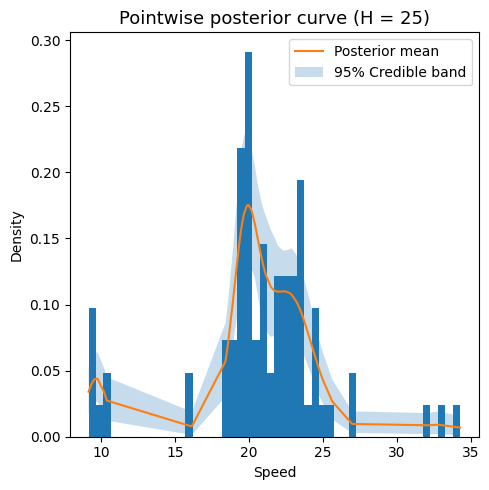

In [21]:
n_mcmc = 2500; burn_in = 2500

## hyperparameter
kappa = 100; mu0 = 0
a = 1; b = 1
H = 25

z_samples, pi_samples, mu_samples, tau2_samples = gibbs_sampler(galaxy, H, mu0, kappa, a, b, n_mcmc, burn_in)
posterior_mean, posterior_interval = model_averaging(galaxy, pi_samples, mu_samples, tau2_samples)

#### ii) H = 15

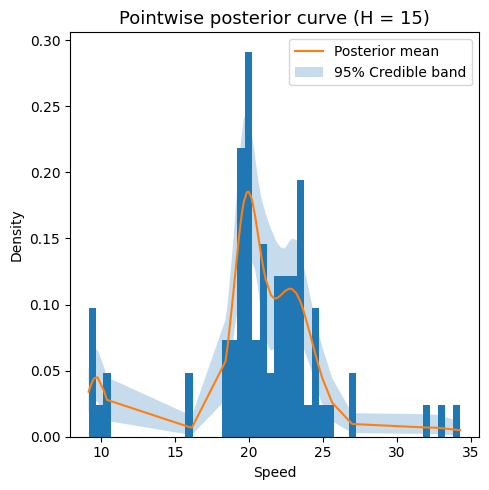

In [20]:
n_mcmc = 2500; burn_in = 2500

## hyperparameter
kappa = 100; mu0 = 0
a = 1; b = 1
H = 15

z_samples, pi_samples, mu_samples, tau2_samples = gibbs_sampler(galaxy, H, mu0, kappa, a, b, n_mcmc, burn_in)
posterior_mean, posterior_interval = model_averaging(galaxy, pi_samples, mu_samples, tau2_samples)

#### iii) H = 4

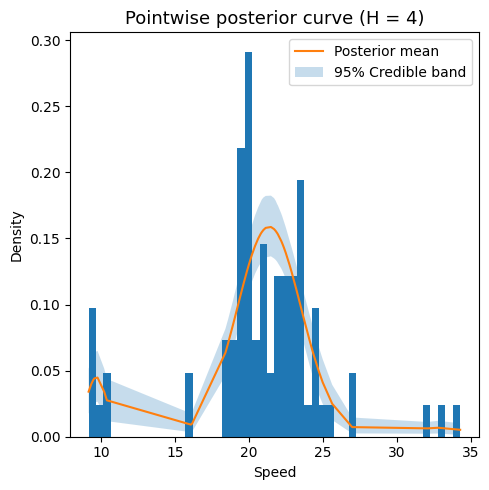

In [14]:
n_mcmc = 2500; burn_in = 2500

## hyperparameter
kappa = 100; mu0 = 0
a = 1; b = 1
H = 4

z_samples, pi_samples, mu_samples, tau2_samples = gibbs_sampler(galaxy, H, mu0, kappa, a, b, n_mcmc, burn_in)
posterior_mean, posterior_interval = model_averaging(galaxy, pi_samples, mu_samples, tau2_samples)